In [34]:
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.crs import CRS
from rasterio.windows import Window
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.interpolate import UnivariateSpline
import os
from pathlib import Path
import pickle
import warnings


import tensorflow as tf
import tensorflow_probability as tfp
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

import contextily as ctx  # for basemaps
from pyproj import Transformer


### 1 GEOSPATIAL DATA PREPROCESSING

In [2]:
def align_and_stack_rasters(raster_dir, output_dir, target_crs_string, reference_file):
    
    print("=" * 60)
    print("Geospatial Data Preprocessing")
    print("=" * 60)
    
    # Feature names
    FEATURES = [
        'AllRoads_1km', 'Altitude_1km', 'Industrial_1km',
        'MajorRoads_1km', 'Nature_1km', 'Ports_1km',
        'Residential_1km', 'TotalBuild_1km', 'UrbanGreen_1km'
    ]
    
    # Get input files
    input_files = [os.path.join(raster_dir, f"{feat}.tif") for feat in FEATURES]
    
    # Process reference raster
    print(f"Processing reference: {reference_file}")
    ref_path = os.path.join(raster_dir, reference_file)
    
    target_crs = CRS.from_string(target_crs_string)
    
    with rasterio.open(ref_path) as src:
        # Get original CRS
        src_crs = src.crs
        
        # Calculate transform for reprojection
        ref_transform, ref_width, ref_height = calculate_default_transform(
            src_crs, target_crs, src.width, src.height, *src.bounds
        )
        
        ref_profile = src.profile.copy()
        ref_profile.update({
            'crs': target_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height
        })
    
    # Create aligned folder
    aligned_dir = os.path.join(output_dir, 'aligned_tifs')
    os.makedirs(aligned_dir, exist_ok=True)
    
    # Process each raster
    aligned_files = []
    for file_path in input_files:
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found")
            continue
        
        filename = os.path.basename(file_path)
        print(f"Aligning {filename}...")
        
        with rasterio.open(file_path) as src:
            # Get the actual source CRS from the file
            src_crs = src.crs
            
            # Handle missing CRS
            if src_crs is None:
                print(f"  Warning: No CRS found in {filename}, assuming target CRS")
                src_crs = target_crs
            
            # Create output profile
            dst_profile = src.profile.copy()
            dst_profile.update({
                'crs': target_crs,
                'transform': ref_transform,
                'width': ref_width,
                'height': ref_height
            })
            
            output_path = os.path.join(aligned_dir, f"aligned_{filename}")
            with rasterio.open(output_path, 'w', **dst_profile) as dst:
                for i in range(1, src.count + 1):
                    # Reproject using the actual source CRS
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src_crs,
                        dst_transform=ref_transform,
                        dst_crs=target_crs,
                        resampling=Resampling.bilinear
                    )
            
            aligned_files.append(output_path)
            print(f"  Successfully aligned {filename}")
    
    # Stack aligned rasters
    print("\nStacking rasters...")
    output_file = os.path.join(output_dir, 'stacked_features.tif')
    
    with rasterio.open(aligned_files[0]) as first_src:
        profile = first_src.profile.copy()
        profile.update({'count': len(aligned_files)})
        
        with rasterio.open(output_file, 'w', **profile) as dst:
            for i, file_path in enumerate(aligned_files, 1):
                with rasterio.open(file_path) as src:
                    dst.write(src.read(1), i)
    
    print(f"\n✓ Stacked raster saved: {output_file}")
    print(f"  Bands: {len(aligned_files)}")
    print(f"  Dimensions: {ref_width} x {ref_height}")
    return output_file

### 2 EDA

In [3]:
def parse_pm25_data(filepath):
    """Parse UK-AIR PM2.5 data"""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # Parse metadata
        site_names = lines[3].strip().split(',,')[1:]
        latitudes = lines[4].strip().split(',,')[1:]
        longitudes = lines[5].strip().split(',,')[1:]
        
        stations = []
        for i, name in enumerate(site_names):
            if i < len(latitudes) and i < len(longitudes):
                try:
                    lat = float(latitudes[i].strip('"'))
                    lon = float(longitudes[i].strip('"'))
                    if -8 <= lon <= 2 and 49 <= lat <= 61:  # UK bounds
                        stations.append({
                            'name': name.strip('"'),
                            'lat': lat,
                            'lon': lon,
                            'col': i + 1
                        })
                except ValueError:
                    continue
        
        # Parse data rows
        pm25_data = []
        for line in lines[8:]:
            values = line.strip().split(',')
            if not values[0].startswith('20'):
                continue
            for station in stations:
                col_idx = station['col'] * 4 - 2
                if col_idx < len(values):
                    try:
                        pm25_val = float(values[col_idx].strip('"'))
                        if 0 < pm25_val < 500:
                            pm25_data.append({
                                'station_id': station['name'],
                                'latitude': station['lat'],
                                'longitude': station['lon'],
                                'pm25': pm25_val
                            })
                    except ValueError:
                        continue
        
        return pd.DataFrame(pm25_data)
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None

In [4]:
def load_pm25_data(pm25_2020_file, pm25_2021_2025_file):
    """Load and aggregate PM2.5 data"""
    dfs = []
    for filepath in [pm25_2020_file, pm25_2021_2025_file]:
        df = parse_pm25_data(filepath)
        if df is not None:
            dfs.append(df)
    
    if not dfs:
        raise ValueError("No PM2.5 data loaded")
    
    # Aggregate by station
    df_combined = pd.concat(dfs, ignore_index=True)
    df_stations = df_combined.groupby('station_id').agg(
        latitude=('latitude', 'first'),
        longitude=('longitude', 'first'),
        pm25_mean=('pm25', 'mean'),
        pm25_std=('pm25', 'std'),
        count=('pm25', 'size')
    ).reset_index()
    
    # Convert to GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in
                zip(df_stations['longitude'], df_stations['latitude'])]
    gdf = gpd.GeoDataFrame(df_stations, geometry=geometry, crs='EPSG:4326')
    
    print(f"Loaded {len(gdf)} PM2.5 monitoring stations")
    print(f"PM2.5 range: {df_stations['pm25_mean'].min():.2f} - "
          f"{df_stations['pm25_mean'].max():.2f} μg/m³")
    
    return gdf

In [5]:
def extract_features(gdf, raster_file, features):
    """Extract features from raster for each station"""
    with rasterio.open(raster_file) as src:
        # Transform to raster CRS
        gdf_proj = gdf.to_crs(src.crs)
        
        features_data = []
        for _, station in gdf_proj.iterrows():
            row, col = src.index(station.geometry.x, station.geometry.y)
            
            if 0 <= row < src.height and 0 <= col < src.width:
                feature_dict = {
                    'station_id': station['station_id'],
                    'pm25_mean': float(station['pm25_mean'])
                }
                
                for i, feature_name in enumerate(features, 1):
                    value = src.read(i)[row, col]
                    feature_dict[feature_name] = float(value) if np.isfinite(value) else np.nan
                
                features_data.append(feature_dict)
        
        features_df = pd.DataFrame(features_data)
        
        # Fill missing values
        numeric_columns = features_df.select_dtypes(include=[np.number]).columns
        features_df[numeric_columns] = features_df[numeric_columns].fillna(
            features_df[numeric_columns].median()
        )
        
        return features_df

In [6]:
def remove_multicollinear_features(features_df, vif_threshold=10):
    """
    Remove features with high VIF to address multicollinearity
    """
    print(f"\n{'='*60}")
    print(f"Multicollinearity Analysis (VIF Threshold = {vif_threshold})")
    print(f"{'='*60}")
    
    feature_cols = [col for col in features_df.columns
                   if col not in ['station_id', 'pm25_mean']]
    
    # Calculate initial VIF
    X = features_df[feature_cols].values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_cols
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(len(feature_cols))]
    
    print("\nInitial VIF values:")
    print(vif_data.sort_values('VIF', ascending=False))
    
    # Iteratively remove features with highest VIF
    removed_features = []
    remaining_features = feature_cols.copy()
    
    while True:
        X = features_df[remaining_features].values
        vif_values = [variance_inflation_factor(X, i) for i in range(len(remaining_features))]
        max_vif = max(vif_values)
        
        if max_vif <= vif_threshold:
            break
        
        # Remove feature with highest VIF
        max_vif_idx = vif_values.index(max_vif)
        removed_feature = remaining_features[max_vif_idx]
        removed_features.append(removed_feature)
        remaining_features.remove(removed_feature)
        
        print(f"Removed '{removed_feature}' with VIF = {max_vif:.2f}")
    
    print(f"\n{'='*60}")
    print(f"Features removed due to high VIF:")
    for feat in removed_features:
        print(f"  - {feat}")
    
    print(f"\nRemaining features:")
    for feat in remaining_features:
        print(f"  + {feat}")
    print(f"{'='*60}\n")
    
    # Create cleaned dataset
    cleaned_df = features_df[['station_id', 'pm25_mean'] + remaining_features]
    
    return cleaned_df, removed_features, remaining_features

In [ ]:
def analyze_nonlinear_relationships(features_df, feature_cols):
    """
    Analyze and visualize nonlinear relationships
    """
    print("Nonlinear Relationship Analysis")
    
    
    # Visualize nonlinear relationships
    fig, axes = plt.subplots(2, min(3, len(feature_cols)), figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(feature_cols[:6]):
        if feature in features_df.columns:
            ax = axes[idx]
            
            # Scatter plot with nonlinear fit
            x = features_df[feature].values
            y = features_df['pm25_mean'].values
            
            # Remove NaN values
            mask = ~(np.isnan(x) | np.isnan(y))
            x_clean = x[mask]
            y_clean = y[mask]
            
            # Scatter plot
            ax.scatter(x_clean, y_clean, alpha=0.5, s=30)
            
            # Add nonlinear fit (spline)
            if len(x_clean) > 3:
                sorted_idx = np.argsort(x_clean)
                x_sorted = x_clean[sorted_idx]
                y_sorted = y_clean[sorted_idx]
                
                try:
                    # Fit spline
                    spline = UnivariateSpline(x_sorted, y_sorted, s=len(x_sorted))
                    x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 100)
                    y_smooth = spline(x_smooth)
                    ax.plot(x_smooth, y_smooth, 'r-', linewidth=2,
                           label='Nonlinear fit')
                except:
                    pass
            
            # Add linear fit for comparison
            if len(x_clean) > 1:
                z = np.polyfit(x_clean, y_clean, 1)
                p = np.poly1d(z)
                ax.plot(x_clean, p(x_clean), 'b--', alpha=0.5,
                       label='Linear fit')
            
            ax.set_xlabel(feature)
            ax.set_ylabel('PM2.5 (μg/m³)')
            ax.set_title(f'{feature} vs PM2.5')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Nonlinear Relationships Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()

In [8]:
def validate_model(features_df, remaining_features, random_state=42):
    """
    Validate model using train-test split with proper metrics
    """
    print("Model Validation with Train-Test Split")
    
    # Prepare features and target
    feature_cols = [col for col in remaining_features
                   if col not in ['station_id', 'pm25_mean']]
    
    X = features_df[feature_cols]
    y = features_df['pm25_mean']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )
    
    print(f"\nData split:")
    print(f"  Training set: {len(X_train)} samples")
    print(f"  Testing set: {len(X_test)} samples")
    
    # Train Random Forest model
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state,
        max_depth=10
    )
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print("\n" + "-"*40)
    print("Model Performance Metrics:")
    print("-"*40)
    print(f"Training Set:")
    print(f"  R² Score: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f} μg/m³")
    print(f"  MAE: {train_mae:.4f} μg/m³")
    print(f"\nTesting Set:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f} μg/m³")
    print(f"  MAE: {test_mae:.4f} μg/m³")
    
    # Check for overfitting
    overfitting_score = train_r2 - test_r2
    print(f"\nOverfitting Assessment:")
    print(f"  Train-Test R² Difference: {overfitting_score:.4f}")
    if overfitting_score > 0.1:
        print("Model may be overfitting")
    else:
        print("Model shows good generalization")
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n" + "-"*40)
    print("Feature Importance Ranking:")
    print("-"*40)
    for idx, row in importance_df.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    # Visualize predictions vs actual
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Training set
    axes[0].scatter(y_train, y_train_pred, alpha=0.5)
    axes[0].plot([y_train.min(), y_train.max()], 
                 [y_train.min(), y_train.max()], 
                 'r--', lw=2)
    axes[0].set_xlabel('Actual PM2.5 (μg/m³)')
    axes[0].set_ylabel('Predicted PM2.5 (μg/m³)')
    axes[0].set_title(f'Training Set (R² = {train_r2:.3f})')
    axes[0].grid(True, alpha=0.3)
    
    # Testing set
    axes[1].scatter(y_test, y_test_pred, alpha=0.5)
    axes[1].plot([y_test.min(), y_test.max()], 
                 [y_test.min(), y_test.max()], 
                 'r--', lw=2)
    axes[1].set_xlabel('Actual PM2.5 (μg/m³)')
    axes[1].set_ylabel('Predicted PM2.5 (μg/m³)')
    axes[1].set_title(f'Testing Set (R² = {test_r2:.3f})')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Model Validation: Predictions vs Actual', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Create Partial Dependence Plots for top features
    top_features = importance_df['feature'].head(4).tolist()
    if len(top_features) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        for idx, feature in enumerate(top_features):
            display = PartialDependenceDisplay.from_estimator(
                rf, X_train, [feature], ax=axes[idx],
                kind='average', grid_resolution=20
            )
            axes[idx].set_title(f'Partial Dependence: {feature}')
            axes[idx].set_ylabel('Partial Dependence')
        
        plt.suptitle('Partial Dependence Plots (Top Features)', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    return rf, importance_df, {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

In [9]:
def analyze_correlations_and_importance(features_df, cleaned_features):
    """
    Analyze correlations and feature importance on cleaned data
    """
    # Correlation matrix on cleaned features
    numeric_cols = [col for col in cleaned_features if col != 'station_id']
    corr_matrix = features_df[numeric_cols].corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print correlation with PM2.5
    if 'pm25_mean' in corr_matrix.columns:
        pm25_corr = corr_matrix['pm25_mean'].sort_values(ascending=False)
        print("\nCorrelation with PM2.5 (Cleaned Features):")
        print(pm25_corr[pm25_corr.index != 'pm25_mean'])

In [10]:
def main():
    """Main execution function"""
    
    # Configuration parameters
    RASTER_DIR = "/Users/mcy/Downloads/tif/"
    OUTPUT_DIR = "/Users/mcy/Downloads/"
    PM25_2020_FILE = "/Users/mcy/Downloads/uk_pm_2020.csv"
    PM25_2021_2025_FILE = "/Users/mcy/Downloads/uk_pm_2021-2025.csv"
    TARGET_CRS = '+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs'
    VIF_THRESHOLD = 10
    
    # Feature names
    FEATURES = [
        'AllRoads_1km', 'Altitude_1km', 'Industrial_1km',
        'MajorRoads_1km', 'Nature_1km', 'Ports_1km',
        'Residential_1km', 'TotalBuild_1km', 'UrbanGreen_1km'
    ]
    
    try:
        # 1 Geospatial Data Preprocessing
        print("1 GEOSPATIAL DATA PREPROCESSING")

        stacked_file = align_and_stack_rasters(
            RASTER_DIR, OUTPUT_DIR, TARGET_CRS, "Altitude_1km.tif"
        )
        
        # 2 Load PM2.5 data
        print("2 LOADING PM2.5 DATA")
        gdf = load_pm25_data(PM25_2020_FILE, PM25_2021_2025_FILE)
        
        # 3 Extract features
        print("3 EXTRACTING FEATURES FROM RASTER")
        features_df = extract_features(gdf, stacked_file, FEATURES)
        print(f"Extracted features for {len(features_df)} stations")
        
        # 4 Remove multicollinear features
        print("4 REMOVING MULTICOLLINEAR FEATURES")
        cleaned_df, removed_features, remaining_features = remove_multicollinear_features(
            features_df, VIF_THRESHOLD
        )
        
        # 5 Analyze nonlinear relationships
        print("5 ANALYZING NONLINEAR RELATIONSHIPS")
        analyze_nonlinear_relationships(cleaned_df, remaining_features)
        
        # 6 Analyze correlations
        print("6 ANALYZING CORRELATIONS")
        analyze_correlations_and_importance(cleaned_df, remaining_features)
        
        # 7 Validate model with train-test split
        print("7 MODEL VALIDATION")
        model, importance_df, metrics = validate_model(cleaned_df, remaining_features)
        
        # Save results
        output_file = os.path.join(OUTPUT_DIR, "pm25_features_cleaned.csv")
        cleaned_df.to_csv(output_file, index=False)
        
        # Save model metrics
        metrics_file = os.path.join(OUTPUT_DIR, "model_metrics.csv")
        pd.DataFrame([metrics]).to_csv(metrics_file, index=False)
        
        print("Successed!")
        print(f"Cleaned results saved to: {output_file}")
        print(f"Model metrics saved to: {metrics_file}")
        
    except Exception as e:
        print(f"\n Error occurred: {e}")
        import traceback
        traceback.print_exc()



1 GEOSPATIAL DATA PREPROCESSING
Geospatial Data Preprocessing
Processing reference: Altitude_1km.tif
Aligning AllRoads_1km.tif...
  Successfully aligned AllRoads_1km.tif
Aligning Altitude_1km.tif...
  Successfully aligned Altitude_1km.tif
Aligning Industrial_1km.tif...
  Successfully aligned Industrial_1km.tif
Aligning MajorRoads_1km.tif...
  Successfully aligned MajorRoads_1km.tif
Aligning Nature_1km.tif...
  Successfully aligned Nature_1km.tif
Aligning Ports_1km.tif...
  Successfully aligned Ports_1km.tif
Aligning Residential_1km.tif...
  Successfully aligned Residential_1km.tif
Aligning TotalBuild_1km.tif...
  Successfully aligned TotalBuild_1km.tif
Aligning UrbanGreen_1km.tif...
  Successfully aligned UrbanGreen_1km.tif

Stacking rasters...

✓ Stacked raster saved: /Users/mcy/Downloads/stacked_features.tif
  Bands: 9
  Dimensions: 3500 x 4172
2 LOADING PM2.5 DATA
Loaded 72 PM2.5 monitoring stations
PM2.5 range: 3.62 - 11.02 μg/m³
3 EXTRACTING FEATURES FROM RASTER
Extracted features

/var/folders/zl/70659_6j65n5ryg2ztlhfx3w0000gn/T/ipykernel_44685/3097775453.py:56: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spline = UnivariateSpline(x_sorted, y_sorted, s=len(x_sorted))


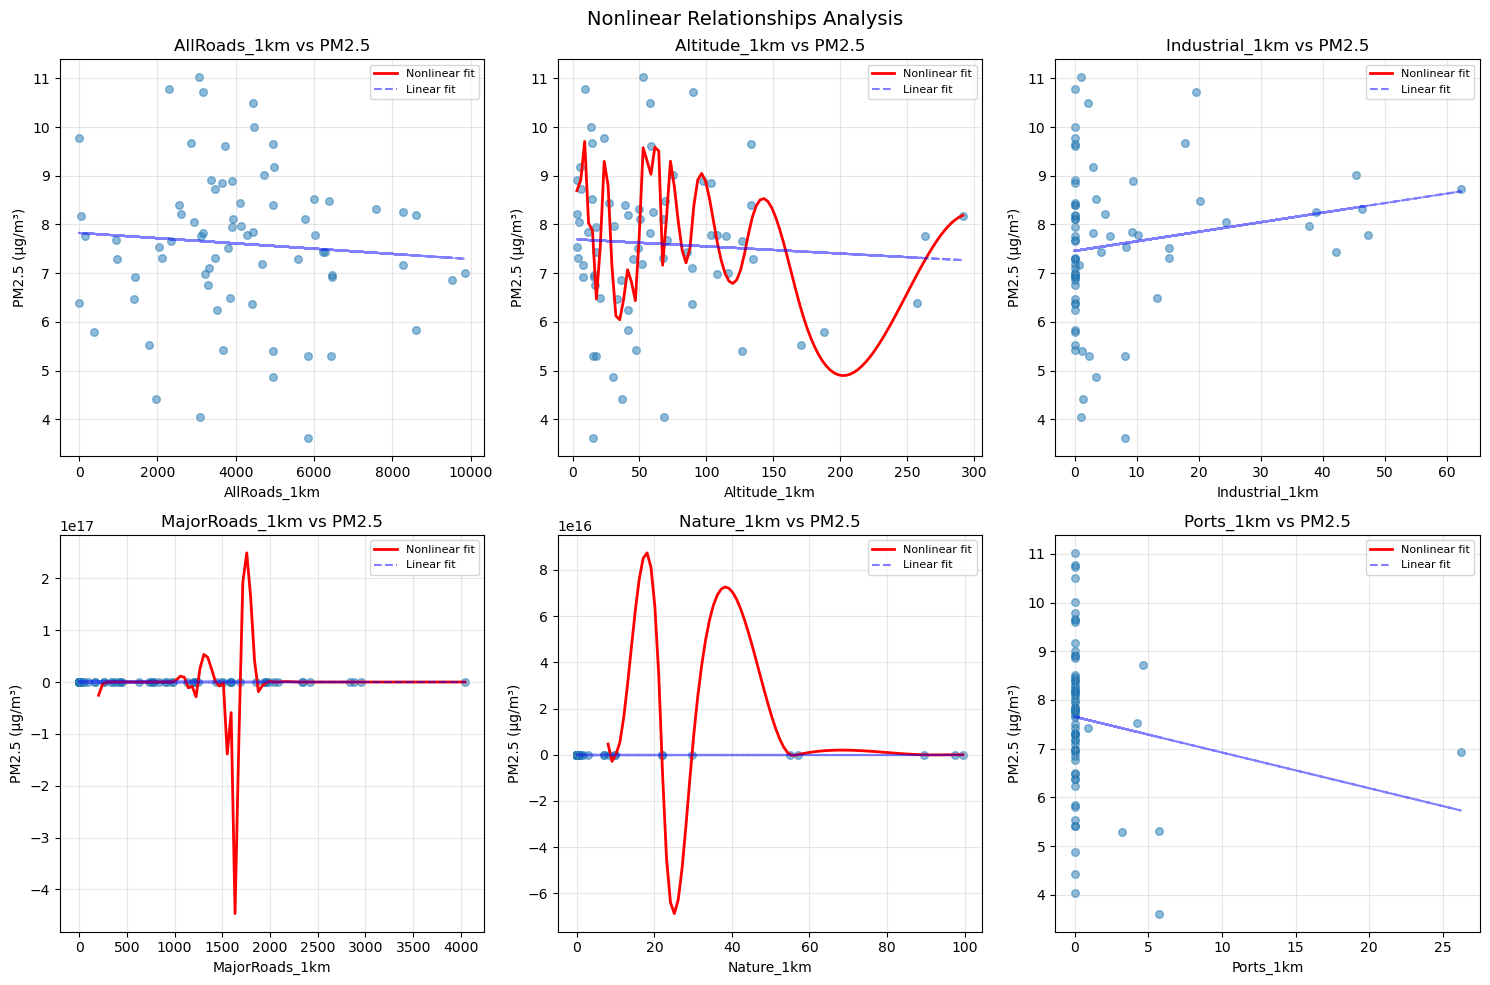

6 ANALYZING CORRELATIONS


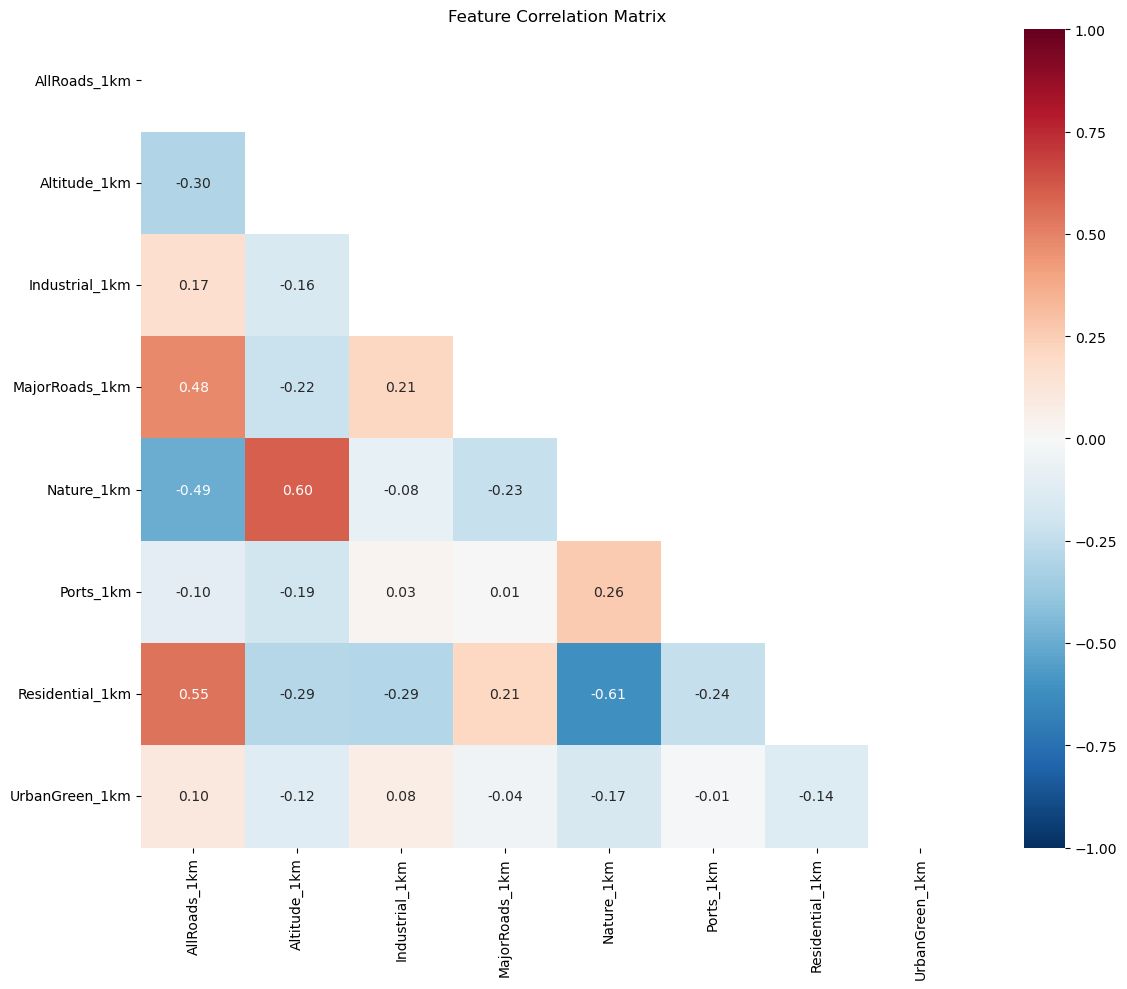

7 MODEL VALIDATION
Model Validation with Train-Test Split

Data split:
  Training set: 50 samples
  Testing set: 22 samples

----------------------------------------
Model Performance Metrics:
----------------------------------------
Training Set:
  R² Score: 0.8081
  RMSE: 0.7137 μg/m³
  MAE: 0.5269 μg/m³

Testing Set:
  R² Score: 0.0981
  RMSE: 1.2167 μg/m³
  MAE: 0.8767 μg/m³

Overfitting Assessment:
  Train-Test R² Difference: 0.7101
Model may be overfitting

----------------------------------------
Feature Importance Ranking:
----------------------------------------
  Residential_1km: 0.2246
  Altitude_1km: 0.1792
  AllRoads_1km: 0.1588
  MajorRoads_1km: 0.1310
  Industrial_1km: 0.1204
  Ports_1km: 0.0820
  UrbanGreen_1km: 0.0659
  Nature_1km: 0.0380


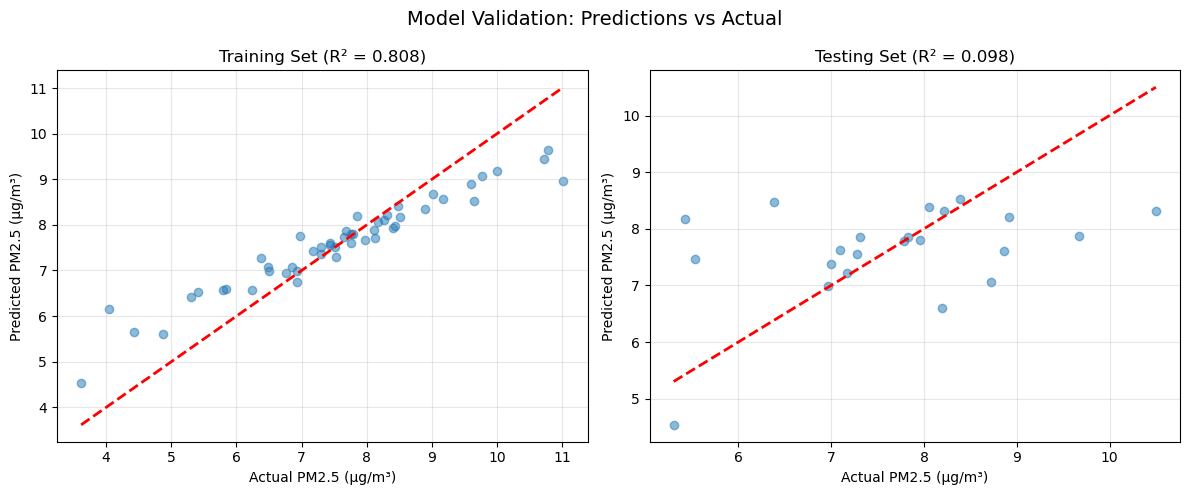

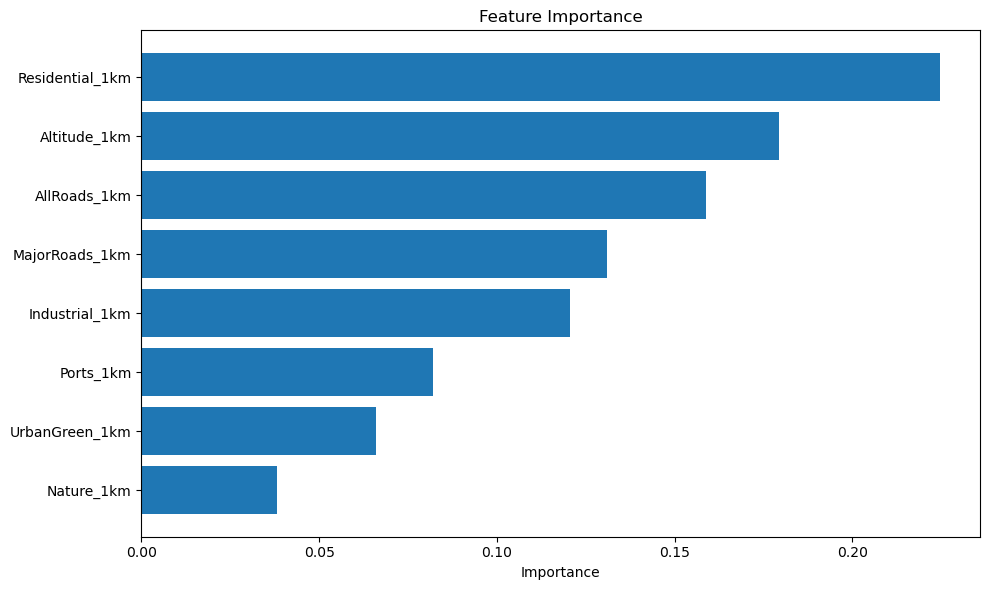

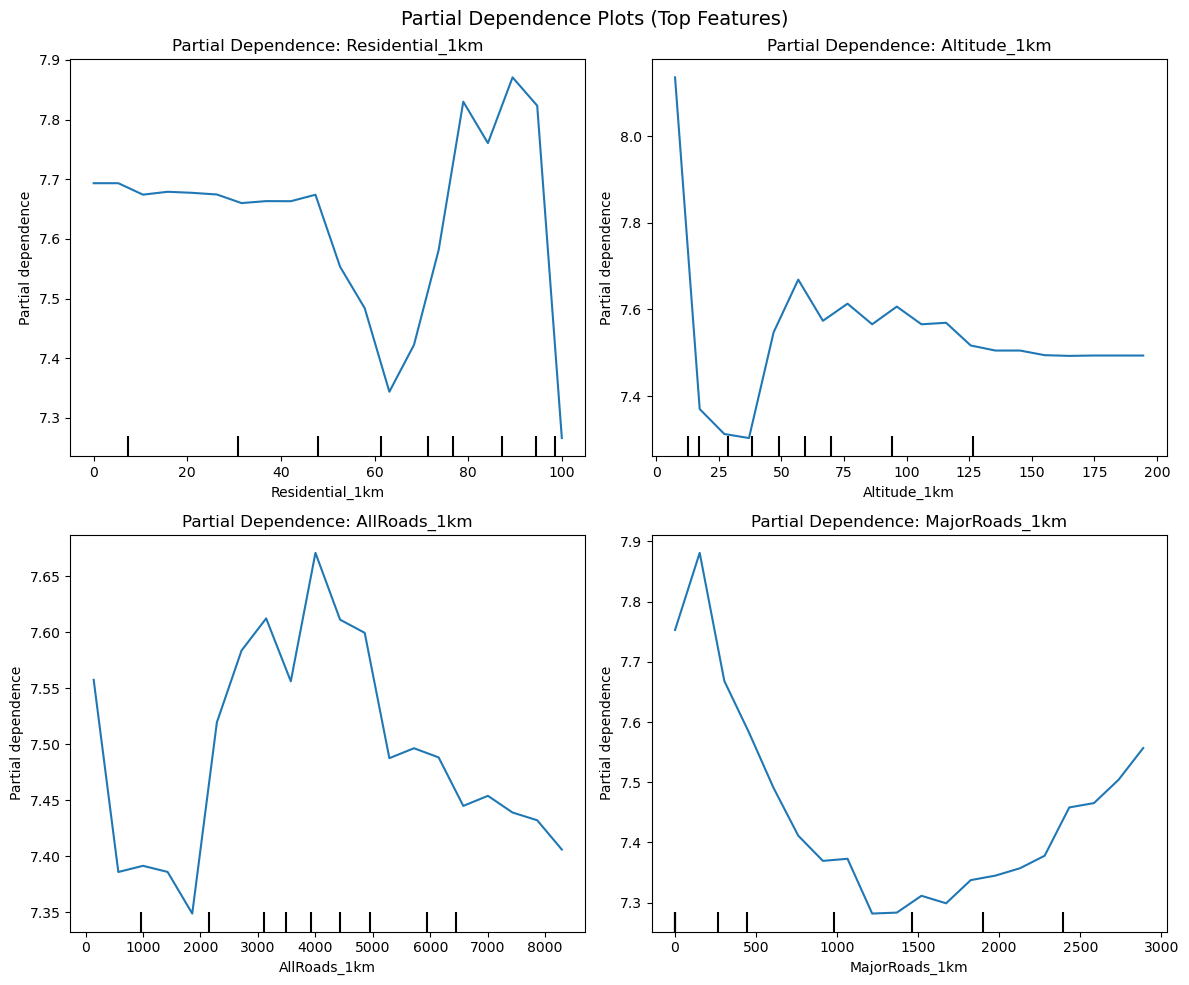

Successed!
Cleaned results saved to: /Users/mcy/Downloads/pm25_features_cleaned.csv
Model metrics saved to: /Users/mcy/Downloads/model_metrics.csv


In [11]:
if __name__ == "__main__":
    main()

### 3 Data preparation

In [12]:
# Configuration Parameters
RASTER_FILE = "/Users/mcy/Downloads/stacked_features.tif"
PM25_2020_FILE = "/Users/mcy/Downloads/uk_pm_2020.csv"
PM25_2021_2025_FILE = "/Users/mcy/Downloads/uk_pm_2021-2025.csv"
OUTPUT_PATH = "/Users/mcy/Downloads/"
RANDOM_STATE = 42

In [13]:
# Spatial validation parameters
N_SPATIAL_FOLDS = 5
MIN_STATIONS_PER_FOLD = 3

# Feature Selection
# Based on EDA, remove the feature with the highest VIF (TotalBuild_1km)
ORIGINAL_FEATURES = [
    "AllRoads_1km", "Altitude_1km", "Industrial_1km", "MajorRoads_1km",
    "Nature_1km", "Ports_1km", "Residential_1km", "TotalBuild_1km", "UrbanGreen_1km"
]
FEATURES_TO_REMOVE = ["TotalBuild_1km"]
SELECTED_FEATURES = [feat for feat in ORIGINAL_FEATURES if feat not in FEATURES_TO_REMOVE]
SELECTED_BAND_INDICES = [i + 1 for i, feat in enumerate(ORIGINAL_FEATURES) if feat not in FEATURES_TO_REMOVE]

print(f"Selected features (after removing high VIF): {SELECTED_FEATURES}")
print(f"Total features retained: {len(SELECTED_FEATURES)}")

Selected features (after removing high VIF): ['AllRoads_1km', 'Altitude_1km', 'Industrial_1km', 'MajorRoads_1km', 'Nature_1km', 'Ports_1km', 'Residential_1km', 'UrbanGreen_1km']
Total features retained: 8


In [14]:
def parse_ukair_format(filepath: str) -> pd.DataFrame:

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        print(f"Parsing file: {filepath}")

        site_name_line_idx, lat_line_idx, lon_line_idx, data_start_idx = 3, 4, 5, 8
        if len(lines) <= data_start_idx:
            return None

        site_names_raw = lines[site_name_line_idx].strip().split(',,')[1:]
        latitudes_raw = lines[lat_line_idx].strip().split(',,')[1:]
        longitudes_raw = lines[lon_line_idx].strip().split(',,')[1:]

        stations = []
        for i, name_raw in enumerate(site_names_raw):
            try:
                name = name_raw.strip().strip('"')
                lat = float(latitudes_raw[i].strip().strip('"'))
                lon = float(longitudes_raw[i].strip().strip('"'))
                if name and -8 <= lon <= 2 and 49 <= lat <= 61:
                    stations.append({'name': name, 'lat': lat, 'lon': lon, 'original_col': i + 1})
            except (ValueError, IndexError):
                continue
        
        if not stations: return None
        
        pm25_data = []
        for line in lines[data_start_idx:]:
            values = line.strip().split(',')
            if not values[0].strip().startswith('20'): continue

            for station in stations:
                try:
                    pm25_col_idx = station['original_col'] * 4 - 2
                    if pm25_col_idx < len(values):
                        value_str = values[pm25_col_idx].strip().strip('"')
                        if value_str and 'No data' not in value_str:
                            pm25_value = float(value_str)
                            if 0 < pm25_value < 500:
                                pm25_data.append({
                                    'station_id': station['name'],
                                    'latitude': station['lat'],
                                    'longitude': station['lon'],
                                    'pm25': pm25_value
                                })
                except (ValueError, IndexError):
                    continue
        return pd.DataFrame(pm25_data) if pm25_data else None
    except Exception as e:
        print(f"Error parsing file {filepath}: {e}")
        return None

In [15]:
def load_and_process_defra_data(raster_crs) -> gpd.GeoDataFrame:

    print("\nStep 1: Loading and Aggregating PM2.5 Data")
    print("-" * 50)
    df_list = [parse_ukair_format(fp) for fp in [PM25_2020_FILE, PM25_2021_2025_FILE]]
    df_list = [df for df in df_list if df is not None and not df.empty]
    if not df_list:
        raise FileNotFoundError("All PM2.5 data files are empty or failed to parse.")

    df_combined = pd.concat(df_list, ignore_index=True)
    df_stations = df_combined.groupby('station_id').agg(
        latitude=('latitude', 'first'),
        longitude=('longitude', 'first'),
        pm25_mean=('pm25', 'mean')
    ).reset_index()

    geometry = [Point(lon, lat) for lon, lat in zip(df_stations['longitude'], df_stations['latitude'])]
    gdf_wgs84 = gpd.GeoDataFrame(df_stations, geometry=geometry, crs='EPSG:4326')
    
    print(f"Successfully loaded {len(gdf_wgs84)} PM2.5 monitoring stations")
    return gdf_wgs84.to_crs(raster_crs)

In [16]:
def create_spatial_folds(gdf: gpd.GeoDataFrame, n_folds: int = 5) -> np.ndarray:
    """
    Creates spatial cross-validation folds using K-means clustering.
    """

    print("\nStep 2: Creating Spatial Cross-Validation Folds")
    print("-" * 50)
    coordinates = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
    kmeans = KMeans(n_clusters=n_folds, random_state=RANDOM_STATE, n_init=10)
    spatial_folds = kmeans.fit_predict(coordinates)
    
    unique, counts = np.unique(spatial_folds, return_counts=True)
    print(f"Spatial fold distribution: {dict(zip(unique, counts))}")
    return spatial_folds

In [17]:
def extract_features_simplified(gdf: gpd.GeoDataFrame, raster_file: str, features: list, band_indices: list) -> pd.DataFrame:
    """
    Extracts feature values by taking only the CENTER PIXEL value for each point.
    This simplified version avoids dimensionality inflation, which is ideal for small datasets.
    """
    print("\nStep 3: Feature Extraction")
    print("-" * 50)
    
    features_data = []
    
    with rasterio.open(raster_file) as src:
        # Reproject GDF to match raster CRS if they don't match
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        for _, station in gdf.iterrows():
            # Base dictionary for this station
            station_features = {
                'station_id': station['station_id'],
                'pm25_mean': station['pm25_mean'],
                'easting': station.geometry.x,
                'northing': station.geometry.y
            }

            try:
                # Get the pixel row and column for the station's location
                row, col = src.index(station.geometry.x, station.geometry.y)
                
                # Check bounds: ensure the point is actually inside the raster grid
                if 0 <= row < src.height and 0 <= col < src.width:
                    
                    # Define a 1x1 window to read the single pixel
                    window = Window(col, row, 1, 1)

                    # Read all selected bands for that single pixel efficiently

                    pixel_values = src.read(band_indices, window=window)

                    for i, feature_name in enumerate(features):
                        value = float(pixel_values[i, 0, 0])
                        # Handle potential NoData values from the raster

                        station_features[feature_name] = value if np.isfinite(value) else np.nan
                else:
                    raise IndexError # Trigger the same logic as out-of-bounds
            except IndexError:
                print(f"  - Warning: Station {station['station_id']} is outside raster bounds. Filling features with NaN.")
                for feature_name in features:
                    station_features[feature_name] = np.nan
            
            features_data.append(station_features)

    features_df = pd.DataFrame(features_data)
    
    # Fill any NaNs that were created (e.g., from out-of-bounds stations) with the column median
    if features_df.isnull().values.any():
        print("\nFilling missing values with column medians...")
        for col in features_df.select_dtypes(include=np.number).columns:
            if features_df[col].isnull().any():
                median_val = features_df[col].median()
                features_df[col].fillna(median_val, inplace=True)
    
    print(f"Extracted features for {len(features_df)} stations.")
    print(f"Final feature matrix shape: {features_df.shape}")
    return features_df

In [18]:
def preprocess_features(df: pd.DataFrame) -> (pd.DataFrame, StandardScaler, list):
    """
    Performs a robust preprocessing pipeline: outlier capping, skewness correction, and scaling.
    """
    print("\nStep 4: Robust Data Preprocessing")
    print("-" * 50)
    
    df_processed = df.copy()
    
    # Identify feature columns (excluding identifiers and target)
    feature_cols = [col for col in df.columns if col not in ['station_id', 'pm25_mean']]
    
    # Step 1 & 2: Cap Outliers using IQR
    for col in feature_cols:
        Q1, Q3 = df_processed[col].quantile(0.25), df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        
        outliers = ((df_processed[col] < lower) | (df_processed[col] > upper)).sum()
        if outliers > 0:
            print(f"Feature '{col}': Capping {outliers} outliers.")
        df_processed[col] = df_processed[col].clip(lower, upper)

    # Step 3: Handle Skewness
    for col in feature_cols:
        if abs(df_processed[col].skew()) > 0.75:
            print(f"Feature '{col}': Correcting high skewness.")
            df_processed[col] = np.log1p(df_processed[col])

    # Step 4: Final Scalin
    print("\nApplying StandardScaler to all features.")
    scaler = StandardScaler()
    df_processed[feature_cols] = scaler.fit_transform(df_processed[feature_cols])
    
    return df_processed, scaler, feature_cols

In [19]:

def main():
    """Main execution function"""
    try:
        # Ensure output directory exists
        os.makedirs(OUTPUT_PATH, exist_ok=True)
        
        with rasterio.open(RASTER_FILE) as src:
            raster_crs = src.crs
            print(f"Raster CRS: {raster_crs}")

        # Step 1: Load PM2.5 data
        pm25_gdf = load_and_process_defra_data(raster_crs)

        # Step 2: Create spatial folds
        spatial_folds = create_spatial_folds(pm25_gdf)
        pm25_gdf['spatial_fold'] = spatial_folds

        # Step 3: Extract simplified features
        features_df = extract_features_simplified(
            pm25_gdf, RASTER_FILE, SELECTED_FEATURES, SELECTED_BAND_INDICES
        )

        # Step 4: Apply robust preprocessing
        processed_df, feature_scaler, feature_names = preprocess_features(features_df)

        # Step 5: Save Processed Data
        print("\nStep 5: Saving Processed Data and Scalers")
        print("-" * 50)
        
        # Prepare final data arrays
        X_scaled = processed_df[feature_names].values
        y = processed_df['pm25_mean'].values
        coords = processed_df[['easting', 'northing']].values
        
        # Save data for modeling
        output_file = os.path.join(OUTPUT_PATH, 'robust_pm25_data.npz')
        np.savez_compressed(
            output_file,
            X_scaled=X_scaled,
            y_original=y,
            spatial_folds=spatial_folds,
            feature_names=np.array(feature_names),
            coordinates=coords
        )
        print(f"Saved processed data to: {output_file}")

        # Save the scaler for later use (e.g., on new data)
        scaler_file = os.path.join(OUTPUT_PATH, 'robust_feature_scaler.pkl')
        with open(scaler_file, 'wb') as f:
            pickle.dump(feature_scaler, f)
        print(f"Saved feature scaler to: {scaler_file}")
        
        # Save the full processed dataframe for inspection
        features_file = os.path.join(OUTPUT_PATH, 'robust_features_inspected.csv')
        processed_df.to_csv(features_file, index=False)
        print(f"Saved detailed features to: {features_file}")

        print("\n" + "="*60)
        print("DATA PREPARATION COMPLETED SUCCESSFULLY!")
        print("="*60)

    except Exception as e:
        print(f"\n--- An error occurred ---")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Raster CRS: IGNF:ETRS89LAEA

Step 1: Loading and Aggregating PM2.5 Data
--------------------------------------------------
Parsing file: /Users/mcy/Downloads/uk_pm_2020.csv
Parsing file: /Users/mcy/Downloads/uk_pm_2021-2025.csv
Successfully loaded 72 PM2.5 monitoring stations

Step 2: Creating Spatial Cross-Validation Folds
--------------------------------------------------
Spatial fold distribution: {np.int32(0): np.int64(13), np.int32(1): np.int64(14), np.int32(2): np.int64(21), np.int32(3): np.int64(14), np.int32(4): np.int64(10)}

Step 3: Feature Extraction
--------------------------------------------------
Extracted features for 72 stations.
Final feature matrix shape: (72, 12)

Step 4: Robust Data Preprocessing
--------------------------------------------------
Feature 'easting': Capping 2 outliers.
Feature 'northing': Capping 1 outliers.
Feature 'AllRoads_1km': Capping 1 outliers.
Feature 'Altitude_1km': Capping 3 outliers.
Feature 'Industrial_1km': Capping 8 outliers.
Feature '

### 4 Neural network with Bayesian

In [20]:
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Configuration
DATA_PATH = "/Users/mcy/Downloads/"
DATA_FILE = "robust_pm25_data.npz"


In [21]:
def load_preprocessed_data(path: str, filename: str) -> dict:
    """
    Loads the preprocessed data saved by the preparation script.。
    """
    full_path = os.path.join(path, filename)
    print(f"--- Loading Data from {full_path} ---")
    if not os.path.exists(full_path):
        print(f"Error: Data file not found at {full_path}")
        return None
    
    try:
        data = np.load(full_path, allow_pickle=True)
        print("Data loaded successfully.")
        print(f"Features shape: {data['X_scaled'].shape}")
        print(f"Target shape: {data['y_original'].shape}")
        print(f"Coordinates shape: {data['coordinates'].shape}")
        
        return {
            'X': data['X_scaled'],
            'y': data['y_original'],
            'coordinates': data['coordinates'] 
        }
    except Exception as e:
        print(f"Error loading data file: {e}")
        return None

In [22]:
def nll(y_true, y_pred_dist):
    """
    Negative Log-Likelihood (NLL) loss function.
    """
    return -y_pred_dist.log_prob(y_true)

In [23]:
def build_minimal_bnn(input_shape):
    def prior_fn(kernel_size, bias_size, dtype=None):
        n = kernel_size + bias_size
        return tf.keras.Sequential([tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n, dtype=dtype),scale_diag=tf.ones(n, dtype=dtype)))])
    def posterior_fn(kernel_size, bias_size, dtype=None):
        n = kernel_size + bias_size
        return tf.keras.Sequential([tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n),dtype=dtype),tfp.layers.MultivariateNormalTriL(n)])
    inputs = tf.keras.layers.Input(shape=input_shape)
    features = tfp.layers.DenseVariational(units=16,make_prior_fn=prior_fn,make_posterior_fn=posterior_fn,activation='relu')(inputs)
    params = tfp.layers.DenseVariational(units=tfp.layers.IndependentNormal.params_size(1),make_prior_fn=prior_fn,make_posterior_fn=posterior_fn)(features)
    outputs = tfp.layers.IndependentNormal(1)(params)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=nll,metrics=['mse'])
    return model

In [24]:
def build_simple_bnn_with_dropout(input_shape, dropout_rate=0.1):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1)])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mse',metrics=['mae'])
    return model

In [25]:
def predict_with_uncertainty_variational(model, X, n_samples=200):
    predictions = np.zeros((n_samples, X.shape[0]))
    print(f"Generating predictions with {n_samples} Monte Carlo samples...")
    for i in range(n_samples):
        y_pred_dist = model(X, training=False)
        predictions[i, :] = y_pred_dist.mean().numpy().flatten()
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

In [26]:
def predict_with_uncertainty_dropout(model, X, n_samples=200):
    predictions = np.zeros((n_samples, X.shape[0]))
    print(f"Generating predictions with {n_samples} Monte Carlo Dropout samples...")
    for i in range(n_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

In [27]:
def plot_results(y_test, mean_preds, std_preds, r2, rmse, model_type="BNN"):
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    ax1 = axes[0]
    ax1.errorbar(y_test,mean_preds,yerr=std_preds,fmt='o',capsize=4,alpha=0.6,ecolor='lightcoral',markersize=4,label='Prediction with Uncertainty')
    perfect_line = np.linspace(min(y_test.min(), mean_preds.min()),max(y_test.max(), mean_preds.max()),100)
    ax1.plot(perfect_line, perfect_line, 'r--', linewidth=2, label='1:1 Line (Perfect Prediction)')
    ax1.set_xlabel("Actual PM2.5 (µg/m³)", fontsize=12)
    ax1.set_ylabel("Predicted PM2.5 (µg/m³)", fontsize=12)
    ax1.set_title(f"{model_type} Predictions vs. Actual Values\n(Test Set R² = {r2:.3f}, RMSE = {rmse:.2f})", fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax2 = axes[1]
    residuals = y_test - mean_preds
    ax2.errorbar(range(len(residuals)),residuals,yerr=std_preds,fmt='o',capsize=3,alpha=0.6,ecolor='lightblue',markersize=3,label='Residuals with Uncertainty')
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Line')
    ax2.set_xlabel("Sample Index", fontsize=12)
    ax2.set_ylabel("Residual (Actual - Predicted) (µg/m³)", fontsize=12)
    ax2.set_title(f"Prediction Residuals with Uncertainty Bands", fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def main():
    """Main execution function"""
    data = load_preprocessed_data(DATA_PATH, DATA_FILE)
    if data is None:
        print("Failed to load data. Exiting.")
        return
    
    X, y, coordinates = data['X'], data['y'], data['coordinates']

    X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
        X, y, coordinates, test_size=0.25, random_state=RANDOM_STATE
    )
    
    print(f"\nData split: {len(X_train)} training samples, {len(X_test)} testing samples.")
    
    input_shape = (X_train.shape[1],)
    print(f"Input shape: {input_shape}")
    
    # try BNN or MC Dropout
    try:
        print("\nAttempting to build Full Bayesian Neural Network")
        model = build_minimal_bnn(input_shape)
        model_type = "Variational BNN"
        predict_fn = predict_with_uncertainty_variational
        print("Successfully built Variational BNN!")
    except Exception as e:
        print(f"\nVariational BNN failed with error: {e}")
        print("Falling back to MC Dropout approximation")
        model = build_simple_bnn_with_dropout(input_shape, dropout_rate=0.2)
        model_type = "MC Dropout BNN"
        predict_fn = predict_with_uncertainty_dropout
        print("Successfully built MC Dropout model!")
    
    print(f"\n{model_type} Model Summary")
    model.summary()
    
    # train the model
    print(f"\nTraining {model_type} Model")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True,verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6,verbose=1)
    
    y_train_fit = y_train
    if model_type == "Variational BNN":
        y_train_fit = y_train.reshape(-1, 1)

    history = model.fit(
        X_train, y_train_fit,
        epochs=200,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("Model training completed.")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if 'mse' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mse'], label='Training MSE')
        plt.plot(history.history['val_mse'], label='Validation MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title('Training History - MSE')
        plt.legend()
        plt.grid(True, alpha=0.3)
    elif 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('Training History - MAE')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    mean_preds, std_preds = predict_fn(model, X_test, n_samples=200)
    r2 = r2_score(y_test, mean_preds)
    rmse = np.sqrt(mean_squared_error(y_test, mean_preds))
    mae = np.mean(np.abs(y_test - mean_preds))

    print(f"\n--- {model_type} Model Evaluation on Test Set ---")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f} µg/m³")
    print(f"Mean Absolute Error (MAE): {mae:.4f} µg/m³")
    print(f"Average Prediction Uncertainty (Std): {np.mean(std_preds):.4f} µg/m³")

    plot_results(y_test, mean_preds, std_preds, r2, rmse, model_type)

    plt.figure(figsize=(10, 6))
    abs_errors = np.abs(y_test - mean_preds)
    plt.scatter(std_preds, abs_errors, alpha=0.5)
    plt.xlabel('Prediction Uncertainty (Std Dev)', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    plt.title(f'{model_type}: Prediction Uncertainty vs. Absolute Error', fontsize=14)
    if len(std_preds) > 1 and np.std(std_preds) > 0:
        z = np.polyfit(std_preds, abs_errors, 1)
        p = np.poly1d(z)
        plt.plot(std_preds, p(std_preds), "r--", alpha=0.8, label=f'Linear fit (corr={np.corrcoef(std_preds, abs_errors)[0,1]:.3f})')
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nAnalysis Complete")
    print(f"Model Type Used: {model_type}")
    if model_type == "MC Dropout BNN":
        print(" MC Dropout provides a computationally efficient approximation to full Bayesian inference.")
        print("The uncertainty estimates are based on dropout sampling during prediction.")

   

In [52]:
def main():
    """Main execution function"""
    data = load_preprocessed_data(DATA_PATH, DATA_FILE)
    if data is None:
        print("Failed to load data. Exiting.")
        return
    
    X, y, coordinates = data['X'], data['y'], data['coordinates']

    X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
        X, y, coordinates, test_size=0.25, random_state=RANDOM_STATE
    )
    
    print(f"\nData split: {len(X_train)} training samples, {len(X_test)} testing samples.")
    
    input_shape = (X_train.shape[1],)
    print(f"Input shape: {input_shape}")
    
    # Try BNN or MC Dropout
    try:
        print("\nAttempting to build Full Bayesian Neural Network")
        model = build_minimal_bnn(input_shape)
        model_type = "Variational BNN"
        predict_fn = predict_with_uncertainty_variational
        print("Successfully built Variational BNN!")
    except Exception as e:
        print(f"\nVariational BNN failed with error: {e}")
        print("Falling back to MC Dropout approximation")
        model = build_simple_bnn_with_dropout(input_shape, dropout_rate=0.2)
        model_type = "MC Dropout BNN"
        predict_fn = predict_with_uncertainty_dropout
        print("Successfully built MC Dropout model!")
    
    print(f"\n{model_type} Model Summary")
    model.summary()
    
    # Train model
    print(f"\nTraining {model_type} Model")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True,verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6,verbose=1)
    
    y_train_fit = y_train
    if model_type == "Variational BNN":
        y_train_fit = y_train.reshape(-1, 1)

    history = model.fit(
        X_train, y_train_fit,
        epochs=200,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("Model training completed.")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if 'mse' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mse'], label='Training MSE')
        plt.plot(history.history['val_mse'], label='Validation MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title('Training History - MSE')
        plt.legend()
        plt.grid(True, alpha=0.3)
    elif 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('Training History - MAE')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Generate predictions
    mean_preds, std_preds = predict_fn(model, X_test, n_samples=200)
    r2 = r2_score(y_test, mean_preds)
    rmse = np.sqrt(mean_squared_error(y_test, mean_preds))
    mae = np.mean(np.abs(y_test - mean_preds))

    print(f"\n--- {model_type} Model Evaluation on Test Set ---")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f} µg/m³")
    print(f"Mean Absolute Error (MAE): {mae:.4f} µg/m³")
    print(f"Average Prediction Uncertainty (Std): {np.mean(std_preds):.4f} µg/m³")

    plot_results(y_test, mean_preds, std_preds, r2, rmse, model_type)

    plt.figure(figsize=(10, 6))
    abs_errors = np.abs(y_test - mean_preds)
    plt.scatter(std_preds, abs_errors, alpha=0.5)
    plt.xlabel('Prediction Uncertainty (Std Dev)', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    plt.title(f'{model_type}: Prediction Uncertainty vs. Absolute Error', fontsize=14)
    if len(std_preds) > 1 and np.std(std_preds) > 0:
        z = np.polyfit(std_preds, abs_errors, 1)
        p = np.poly1d(z)
        plt.plot(std_preds, p(std_preds), "r--", alpha=0.8, label=f'Linear fit (corr={np.corrcoef(std_preds, abs_errors)[0,1]:.3f})')
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nAnalysis Complete")
    print(f"Model Type Used: {model_type}")
    if model_type == "MC Dropout BNN":
        print("MC Dropout provides a computationally efficient approximation to full Bayesian inference.")
        print("The uncertainty estimates are based on dropout sampling during prediction.")

    # Original uncertainty map
    print("\nGenerating Uncertainty Map")
    df_uncertainty = pd.DataFrame({
        'east': coords_test[:, 0],
        'north': coords_test[:, 1],
        'uncertainty_std': std_preds,
        'abs_error': np.abs(y_test - mean_preds)
    })
    gdf_uncertainty = gpd.GeoDataFrame(
        df_uncertainty, 
        geometry=gpd.points_from_xy(df_uncertainty.east, df_uncertainty.north)
    )
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.set_facecolor('lightgray')
    gdf_all_stations = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coordinates[:, 0], coordinates[:, 1])
    )
    gdf_all_stations.plot(ax=ax, marker='.', color='black', markersize=20, alpha=0.3, label='All Stations')
    plot = gdf_uncertainty.plot(
        ax=ax, 
        column='uncertainty_std', 
        cmap='plasma', 
        legend=True, 
        markersize=(df_uncertainty['uncertainty_std'] / df_uncertainty['uncertainty_std'].max()) * 200 + 50, 
        edgecolor='black', 
        linewidth=0.5, 
        legend_kwds={'label': "Prediction Uncertainty (Std Dev)", 'orientation': "horizontal"}
    )
    ax.set_title("Map of Model Prediction Uncertainty on Test Set", fontsize=16)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    


    mean_preds, std_preds = predict_fn(model, X_test, n_samples=200)
    r2 = r2_score(y_test, mean_preds)
    rmse = np.sqrt(mean_squared_error(y_test, mean_preds))
    mae = np.mean(np.abs(y_test - mean_preds))
    
    # ... [evaluation prints and plots] ...
    
    # Original uncertainty map (keep this)
    print("\nGenerating Uncertainty Map")
    df_uncertainty = pd.DataFrame({
        'east': coords_test[:, 0],
        'north': coords_test[:, 1],
        'uncertainty_std': std_preds,
        'abs_error': np.abs(y_test - mean_preds)
    })
    # ... [rest of original uncertainty map code] ...
    
    # ADD THE UK MAP PROJECTION HERE (inside main function):
    print("\nProjecting uncertainty map to UK real map...")
    
    # Load original PM2.5 data with WGS84 coordinates
    PM25_2020_FILE = "/Users/mcy/Downloads/uk_pm_2020.csv"
    PM25_2021_2025_FILE = "/Users/mcy/Downloads/uk_pm_2021-2025.csv"
    
    pm25_gdf_wgs84 = load_pm25_data(PM25_2020_FILE, PM25_2021_2025_FILE)
    print(f"Loaded {len(pm25_gdf_wgs84)} PM2.5 monitoring stations")
    
    # Get test set indices
    np.random.seed(RANDOM_STATE)
    indices = np.arange(len(pm25_gdf_wgs84))
    train_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=RANDOM_STATE)
    
    # Create test set GeoDataFrame with uncertainty data
    test_gdf_wgs84 = pm25_gdf_wgs84.iloc[test_idx].copy()
    test_gdf_wgs84['uncertainty_std'] = std_preds
    test_gdf_wgs84['predictions'] = mean_preds
    test_gdf_wgs84['actual'] = y_test
    test_gdf_wgs84['error'] = np.abs(y_test - mean_preds)
    
    # Check coordinate ranges
    print(f"Longitude range: {test_gdf_wgs84.geometry.x.min():.2f} to {test_gdf_wgs84.geometry.x.max():.2f}")
    print(f"Latitude range: {test_gdf_wgs84.geometry.y.min():.2f} to {test_gdf_wgs84.geometry.y.max():.2f}")
    
    # Create uncertainty map on UK basemap
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Plot all stations as background
    pm25_gdf_wgs84.plot(
        ax=ax,
        marker='o',
        color='lightgray',
        markersize=30,
        alpha=0.4,
        label='All stations'
    )
    
    # Plot test set with uncertainty coloring
    test_gdf_wgs84.plot(
        column='uncertainty_std',
        ax=ax,
        cmap='plasma',
        legend=True,
        markersize=150,
        edgecolor='black',
        linewidth=1,
        alpha=0.8,
        legend_kwds={'label': 'Prediction Uncertainty (Std Dev)', 'shrink': 0.7}
    )
    
    # Add UK basemap
    import contextily as ctx
    ctx.add_basemap(
        ax,
        crs=test_gdf_wgs84.crs,
        source=ctx.providers.CartoDB.Positron,
        alpha=0.6
    )
    
    ax.set_title('Model Prediction Uncertainty Spatial Distribution (UK Map)', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=11)
    ax.set_ylabel('Latitude', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Final print statements
    print("This map shows the model's predictions of which regions are the most uncertain.")
    print("Areas with high uncertainty (brighter colors and larger points) may indicate")
    print("more complex PM2.5 patterns or insufficient feature explanatory power.")


--- Loading Data from /Users/mcy/Downloads/robust_pm25_data.npz ---
Data loaded successfully.
Features shape: (72, 10)
Target shape: (72,)
Coordinates shape: (72, 2)

Data split: 54 training samples, 18 testing samples.
Input shape: (10,)

Attempting to build Full Bayesian Neural Network

Variational BNN failed with error: 'tuple' object has no attribute 'rank'
Falling back to MC Dropout approximation
Successfully built MC Dropout model!

MC Dropout BNN Model Summary


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)


Training MC Dropout BNN Model
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 64.1515 - mae: 7.8243 - val_loss: 64.6231 - val_mae: 7.9299 - learning_rate: 0.0100
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 57.5546 - mae: 7.3962 - val_loss: 58.7450 - val_mae: 7.5199 - learning_rate: 0.0100
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 50.5504 - mae: 6.9046 - val_loss: 52.7140 - val_mae: 7.0643 - learning_rate: 0.0100
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 44.8632 - mae: 6.4430 - val_loss: 46.4789 - val_mae: 6.5643 - learning_rate: 0.0100
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.6639 - mae: 5.7964 - val_loss: 39.8135 - val_mae: 5.9730 - learning_rate: 0.0100
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30.5240 - mae: 5.1199 - val_loss: 33.0516 - val_mae: 5.2866 - learning_rate: 0.0100
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27.0923 - mae: 4.7651 - val_loss: 26.2673 - val_mae: 4.6193

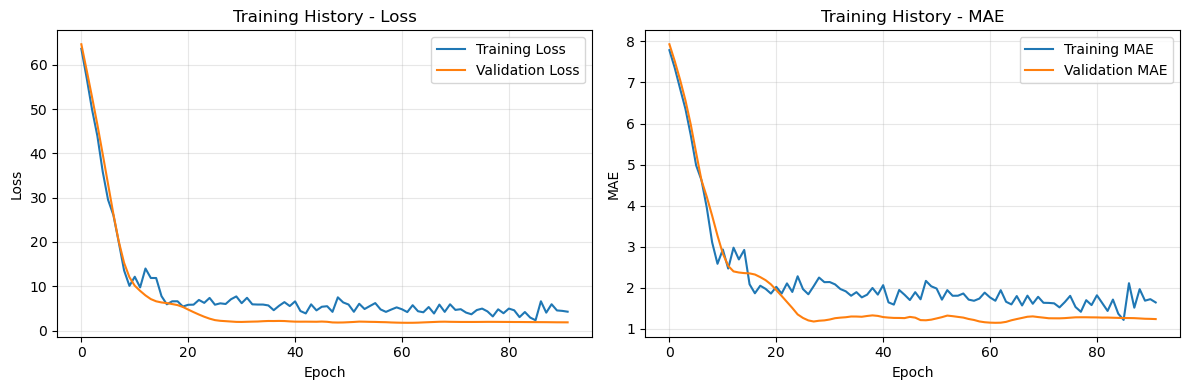

Generating predictions with 200 Monte Carlo Dropout samples...

--- MC Dropout BNN Model Evaluation on Test Set ---
R-squared (R²): -1.3691
Root Mean Squared Error (RMSE): 1.8246 µg/m³
Mean Absolute Error (MAE): 1.4006 µg/m³
Average Prediction Uncertainty (Std): 1.5811 µg/m³


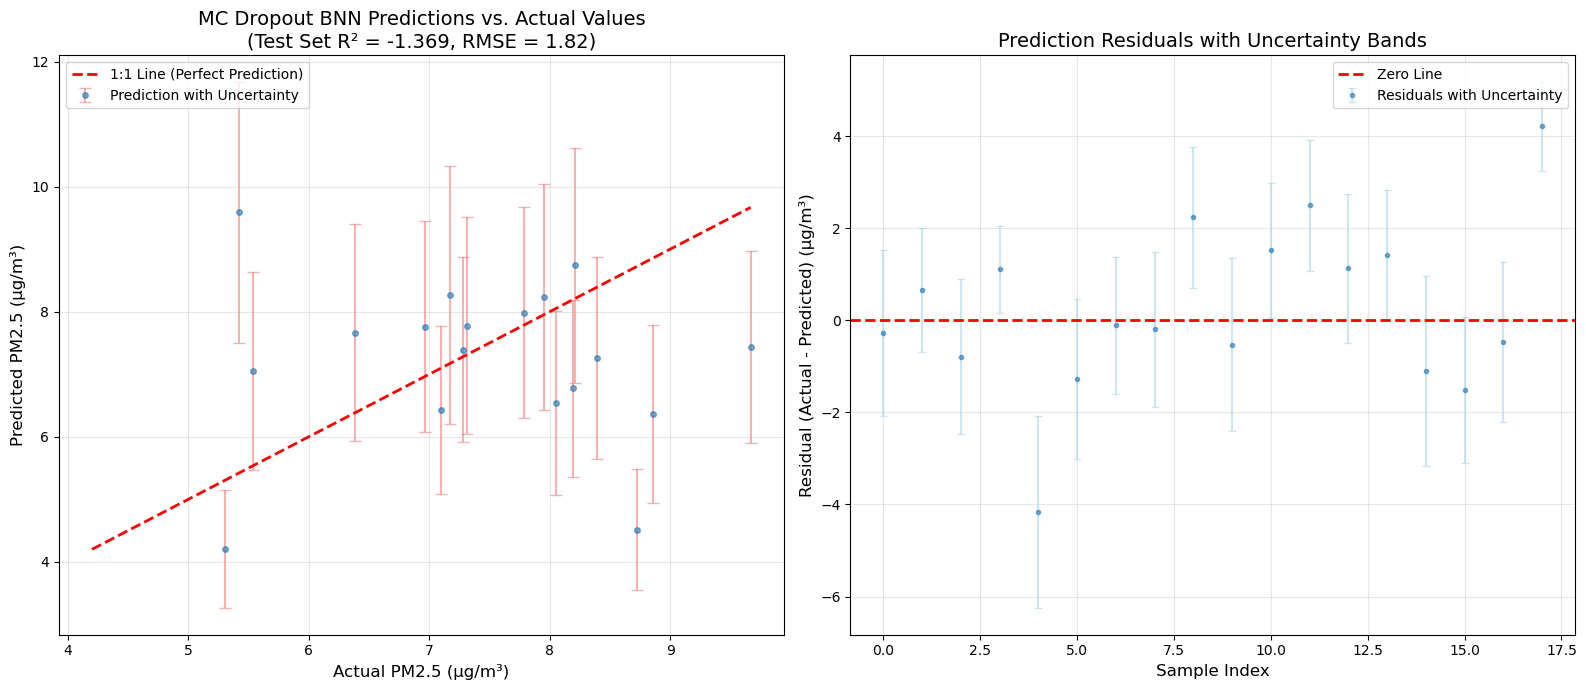

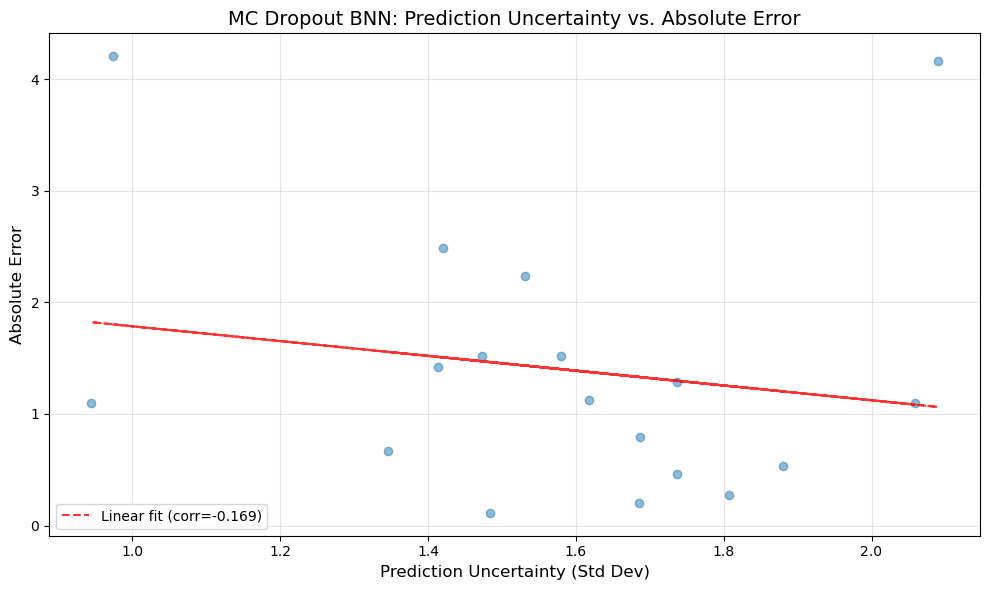


Analysis Complete
Model Type Used: MC Dropout BNN
MC Dropout provides a computationally efficient approximation to full Bayesian inference.
The uncertainty estimates are based on dropout sampling during prediction.

Generating Uncertainty Map


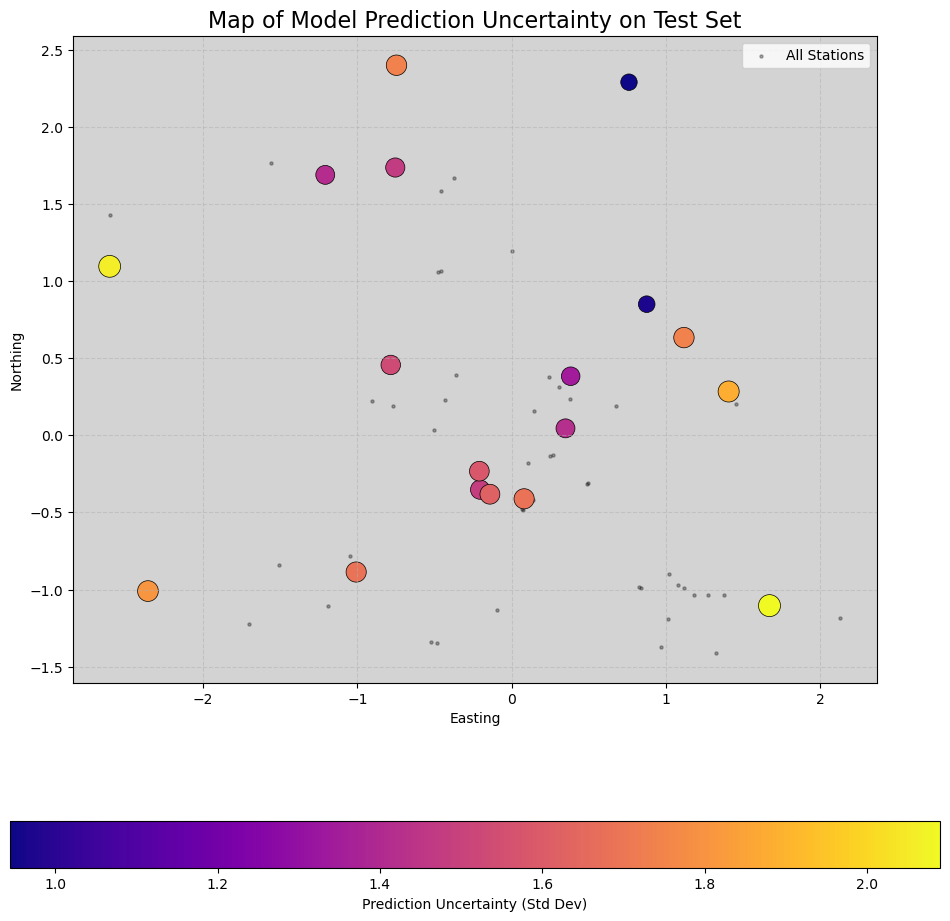

Generating predictions with 200 Monte Carlo Dropout samples...

Generating Uncertainty Map

Projecting uncertainty map to UK real map...
Loaded 72 PM2.5 monitoring stations
PM2.5 range: 3.62 - 11.02 μg/m³
Loaded 72 PM2.5 monitoring stations
Longitude range: -5.93 to 0.55
Latitude range: 51.07 to 57.48


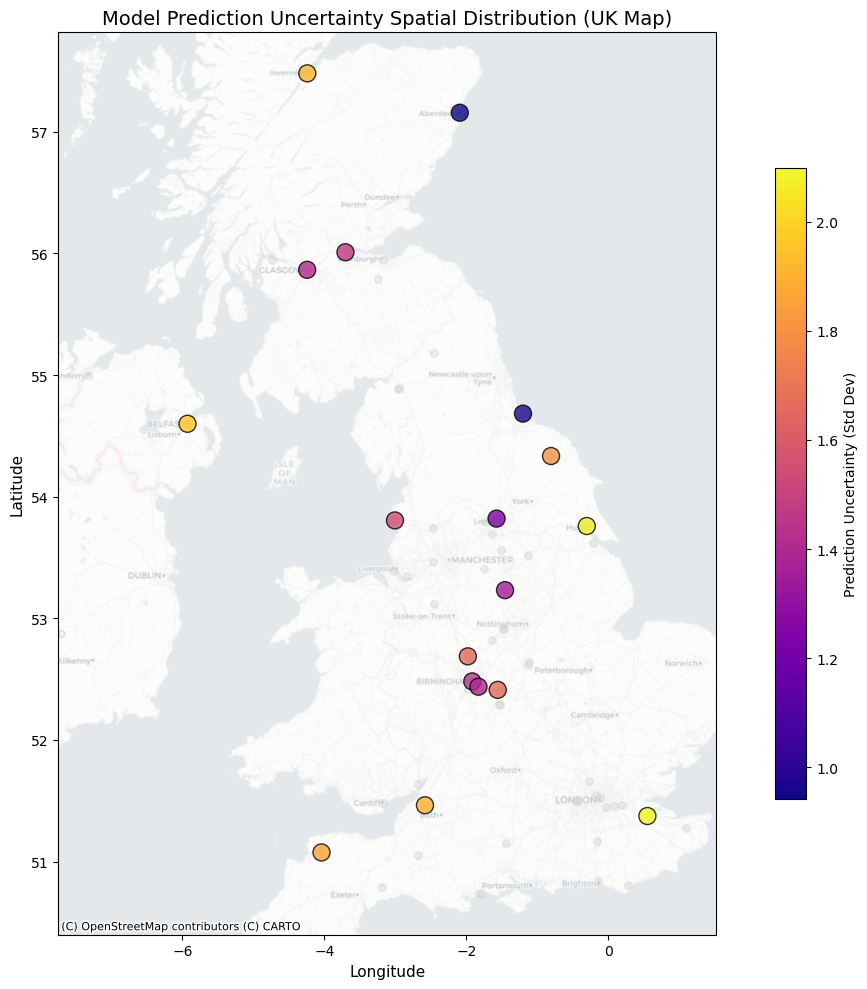

This map shows the model's predictions of which regions are the most uncertain.
Areas with high uncertainty (brighter colors and larger points) may indicate
more complex PM2.5 patterns or insufficient feature explanatory power.


In [53]:
if __name__ == "__main__":
    main()

### 5 gwr analysis

In [30]:
print("--- 1. Loading Preprocessed Data ---")
DATA_PATH = "/Users/mcy/Downloads/"
DATA_FILE = "robust_pm25_data.npz"


try:
    data = np.load(f"{DATA_PATH}{DATA_FILE}", allow_pickle=True)
    X = data['X_scaled']
    y = data['y_original']
    coordinates = data['coordinates']
    feature_names = data['feature_names'].tolist()
    print("Data loaded successfully.")
    print(f"Features loaded: {feature_names}")
    print(f"X shape: {X.shape}, Number of feature names: {len(feature_names)}")
except Exception as e:
    print(f"Failed to load data: {e}")
    exit()

--- 1. Loading Preprocessed Data ---
Data loaded successfully.
Features loaded: ['easting', 'northing', 'AllRoads_1km', 'Altitude_1km', 'Industrial_1km', 'MajorRoads_1km', 'Nature_1km', 'Ports_1km', 'Residential_1km', 'UrbanGreen_1km']
X shape: (72, 10), Number of feature names: 10


Optimal bandwidth found: 70.0
Model type                                                         Gaussian
Number of observations:                                                  72
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            137.582
Log-likelihood:                                                    -125.475
AIC:                                                                270.951
AICc:                                                               277.351
BIC:                                                               -127.572
R2:                                                                   0.186
Adj. R2:                                                              0.067

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------

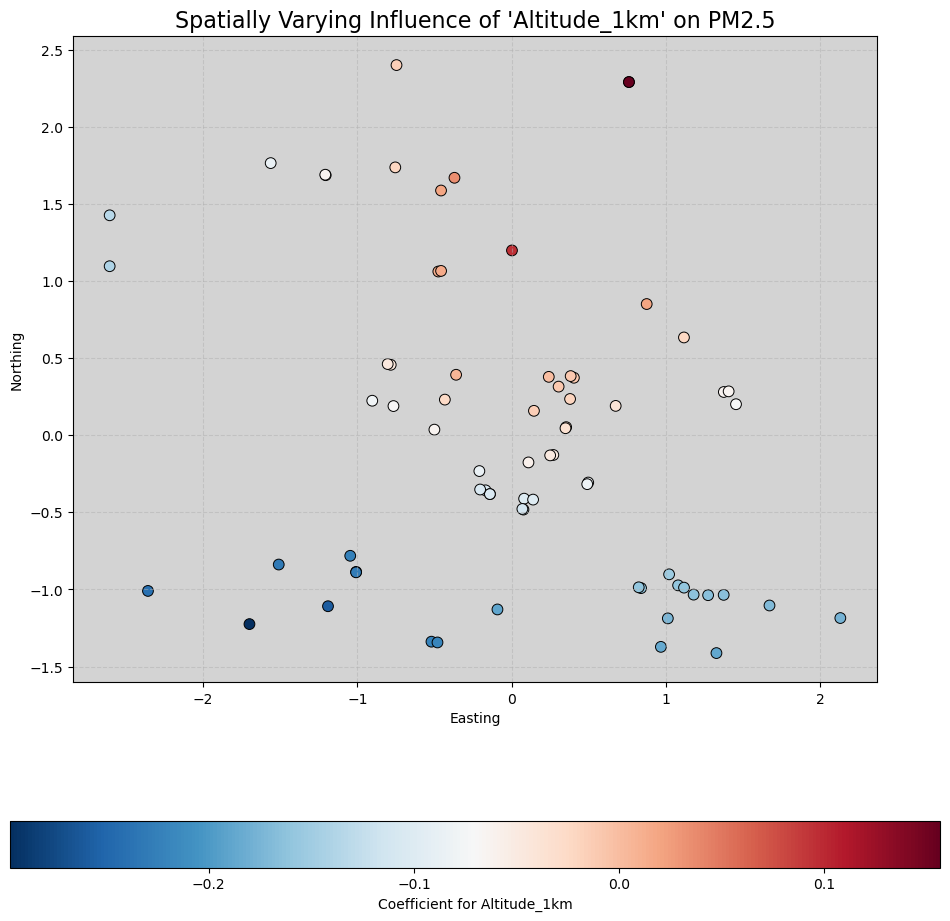

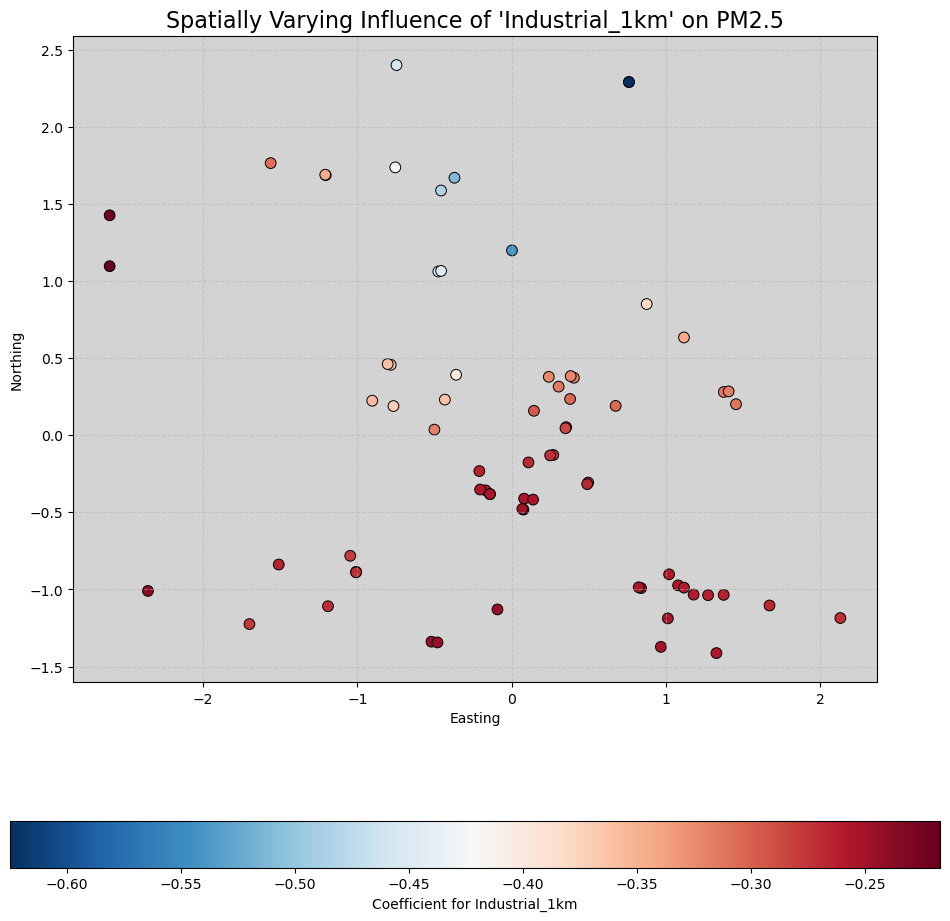

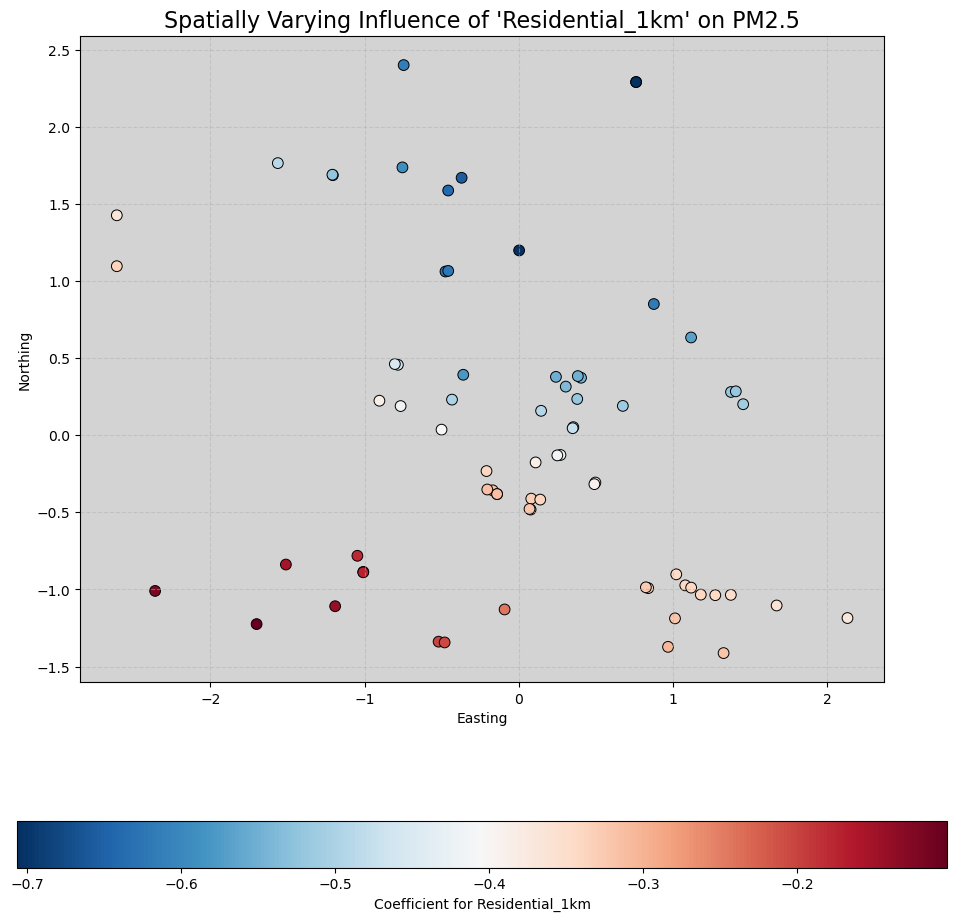

In [31]:
# Reshape y to be a 2D array with one column for GWR
y_gwr = y.reshape(-1, 1)

# Search for optimal bandwidth
# Sel_BW will receive X with 10 feature columns. The model handles the intercept internally.
selector = Sel_BW(coordinates, y_gwr, X, fixed=False, kernel='bisquare')
best_bandwidth = selector.search()
print(f"Optimal bandwidth found: {best_bandwidth}")

# Fitting GWR model
# We pass the original X (10 features). The model fits an intercept automatically.
gwr_model = GWR(coordinates, y_gwr, X, best_bandwidth, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()


print(gwr_results.summary())

# Visualizing Spatially Varying Coefficients


print(f"Shape of gwr_results.params: {gwr_results.params.shape}")
print(f"Number of column names in 'feature_names': {len(feature_names)}")

df_coeffs = pd.DataFrame(gwr_results.params, columns=feature_names)

gdf_results = gpd.GeoDataFrame(
    df_coeffs,
    geometry=gpd.points_from_xy(coordinates[:, 0], coordinates[:, 1])
)


features_to_plot = ['Altitude_1km', 'Industrial_1km', 'Residential_1km']

for feature in features_to_plot:
    if feature in gdf_results.columns:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        

        gdf_results.plot(
            column=feature,
            ax=ax,
            cmap='RdBu_r', # Red-Blue diverging colormap
            legend=True,
            markersize=60,
            edgecolor='black',
            linewidth=0.7,
            legend_kwds={'label': f"Coefficient for {feature}", 'orientation': "horizontal"}
        )
        
        ax.set_title(f"Spatially Varying Influence of '{feature}' on PM2.5", fontsize=16)
        ax.set_xlabel("Easting")
        ax.set_ylabel("Northing")
        ax.set_facecolor('lightgray')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

Loaded 72 PM2.5 monitoring stations
PM2.5 range: 3.62 - 11.02 μg/m³
initials: 72
longitude: -7.33  1.10
latitude: 50.74  57.48


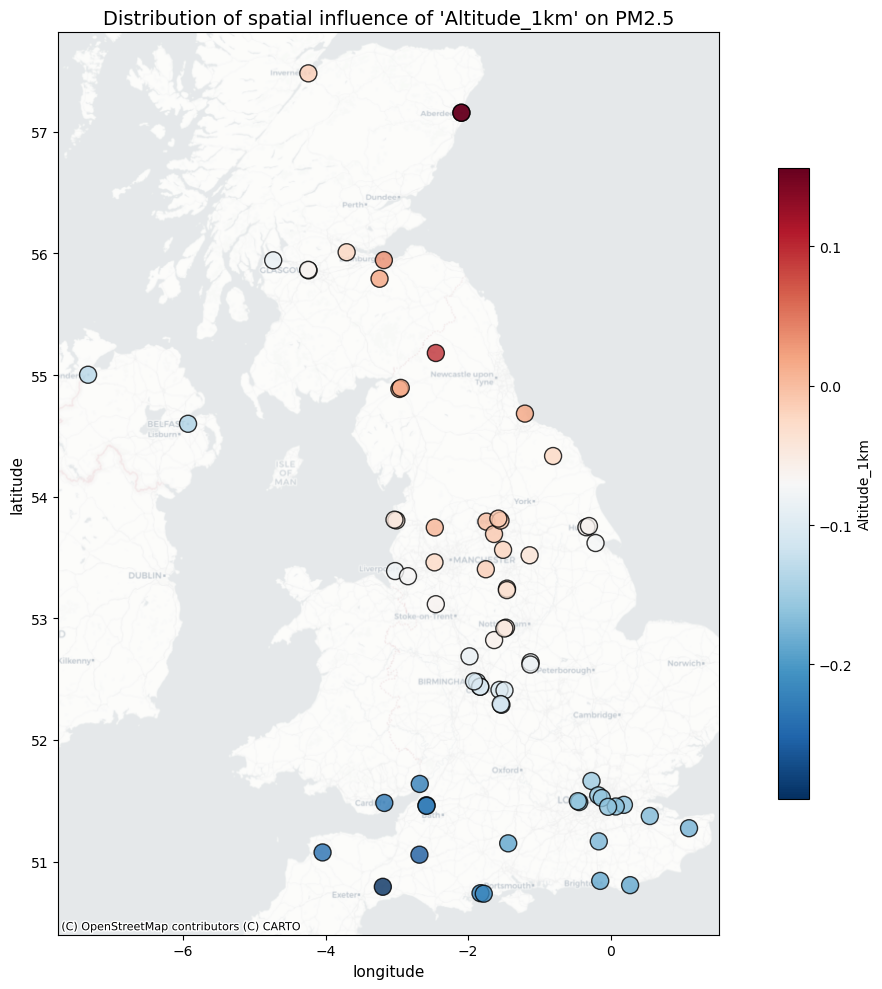

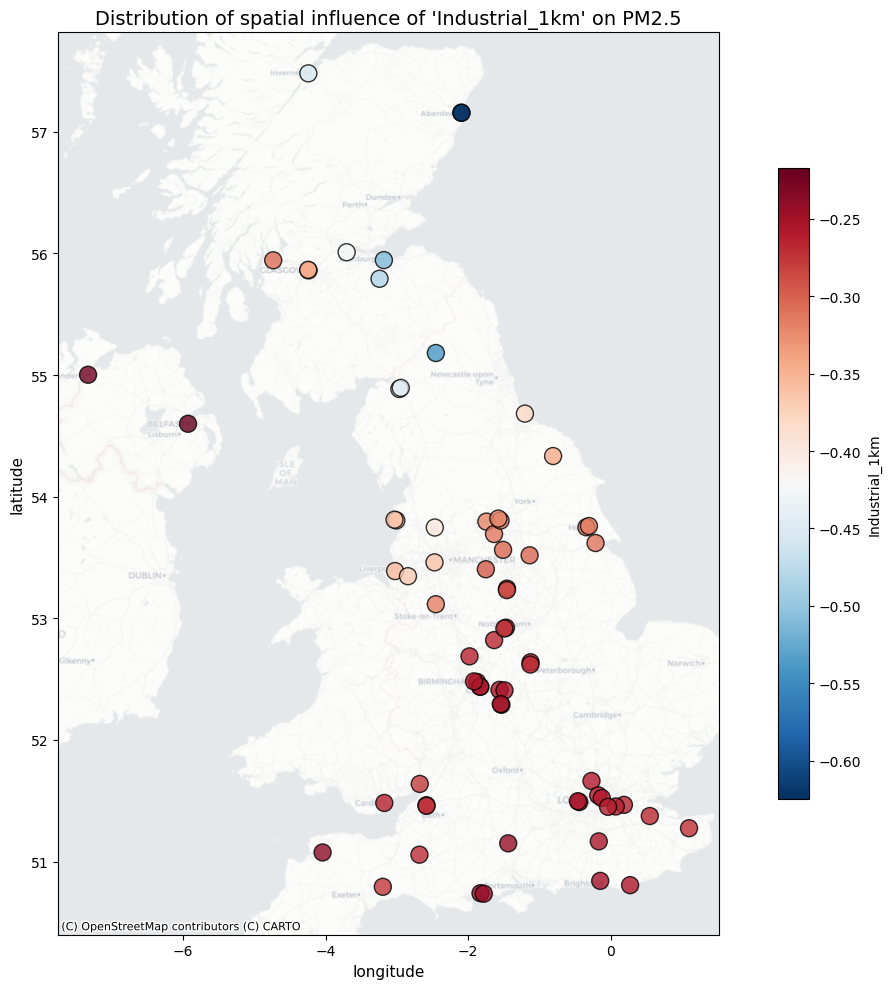

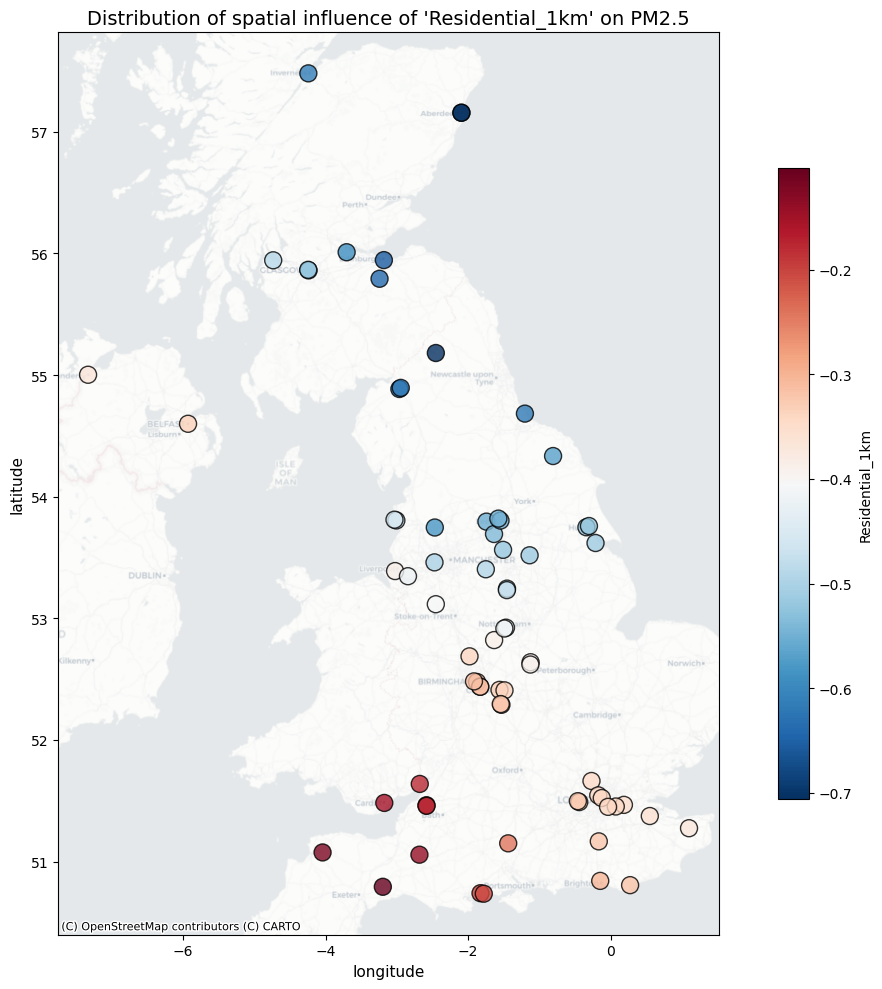

In [44]:


pm25_gdf_wgs84 = load_pm25_data(PM25_2020_FILE, PM25_2021_2025_FILE)
print(f"initials: {len(pm25_gdf_wgs84)}")

gdf_results_wgs84 = pm25_gdf_wgs84.copy()

for i, col in enumerate(feature_names):
    gdf_results_wgs84[col] = gwr_results.params[:, i]


print(f"longitude: {gdf_results_wgs84.geometry.x.min():.2f}  {gdf_results_wgs84.geometry.x.max():.2f}")
print(f"latitude: {gdf_results_wgs84.geometry.y.min():.2f}  {gdf_results_wgs84.geometry.y.max():.2f}")

# mapping
features_to_plot = ['Altitude_1km', 'Industrial_1km', 'Residential_1km']

for feature in features_to_plot:
    if feature in gdf_results_wgs84.columns:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        gdf_results_wgs84.plot(
            column=feature,
            ax=ax,
            cmap='RdBu_r',
            legend=True,
            markersize=150,
            edgecolor='black',
            linewidth=1,
            alpha=0.8,
            legend_kwds={'label': f"{feature}", 'shrink': 0.7}
        )
        

        ctx.add_basemap(
            ax,
            crs=gdf_results_wgs84.crs,
            source=ctx.providers.CartoDB.Positron,
            alpha=0.6
        )
        
        ax.set_title(f"Distribution of spatial influence of '{feature}' on PM2.5", fontsize=14)
        ax.set_xlabel("longitude", fontsize=11)
        ax.set_ylabel("latitude", fontsize=11)
        
        plt.tight_layout()
        plt.show()